<a href="https://colab.research.google.com/github/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/blob/main/RULRVE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/NahuelCostaCortez/Remaining-Useful-Life-Estimation-Variational/

Cloning into 'Remaining-Useful-Life-Estimation-Variational'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 110 (delta 47), reused 28 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (110/110), 64.23 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
cd Remaining-Useful-Life-Estimation-Variational/

/content/Remaining-Useful-Life-Estimation-Variational


In [3]:
import utils
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, Bidirectional, Masking

# Data

In [4]:
dataset = "FD003"
# sensors to work with: T30, T50, P30, PS30, phi
sensors = ['s_3', 's_4', 's_7', 's_11', 's_12']
# windows length
sequence_length = 30
# smoothing intensity
alpha = 0.1
# max RUL
threshold = 125

x_train, y_train, x_val, y_val, x_test, y_test = utils.get_data(dataset, sensors, sequence_length, alpha, threshold)

/content/Remaining-Useful-Life-Estimation-Variational/utils.py:136: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['RUL'].clip(upper=threshold, inplace=True)


# Model

In [5]:
# Setup the network parameters:
timesteps = x_train.shape[1]
input_dim = x_train.shape[2]
intermediate_dim = 300
batch_size = 128
latent_dim = 2
epochs = 10
# used to mask values in sequences with less than 30 cycles until 30 is reached
masking_value = -99.

In [6]:
class Sampling(keras.layers.Layer):
  """Uses (z_mean, sigma) to sample z, the vector encoding an engine trajetory."""
  def call(self, inputs):
    mu, sigma = inputs
    batch = tf.shape(mu)[0]
    dim = tf.shape(mu)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return mu + tf.exp(0.5 * sigma) * epsilon

In [7]:
# ----------------------- Encoder -----------------------
inputs = Input(shape=(timesteps, input_dim,), name='encoder_input')

mask = Masking(mask_value=masking_value)(inputs)

# LSTM encoding
h = Bidirectional(LSTM(intermediate_dim))(mask)

# VAE Z layer
mu = Dense(latent_dim)(h)
sigma = Dense(latent_dim)(h)

z = Sampling()([mu, sigma])

# Instantiate the encoder model:
encoder = keras.Model(inputs, [mu, sigma, z], name='encoder')
print(encoder.summary())
# -------------------------------------------------------

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_input             │ (None, 30, 5)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, 30, 5)          │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ masking (Masking)         │ (None, 30, 5)          │              0 │ encoder_input[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ any (Any)                 │ (None, 30)             │              0 │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 600)            │        734,400 │ masking[0][0],         │
│ (Bidirectional)           │                        │                │ any[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 2)              │          1,202 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 2)              │          1,202 │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ dense[0][0],           │
│                           │                        │                │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 736,804 (2.81 MB)

 Trainable params: 736,804 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# ----------------------- Regressor --------------------
reg_latent_inputs = Input(shape=(latent_dim,), name='z_sampling_reg')
reg_intermediate = Dense(200, activation='tanh')(reg_latent_inputs)
reg_outputs = Dense(1, name='reg_output')(reg_intermediate)
# Instantiate the classifier model:
regressor = keras.Model(reg_latent_inputs, reg_outputs, name='regressor')
print(regressor.summary())
# -------------------------------------------------------

Model: "regressor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling_reg (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 200)                 │             600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reg_output (Dense)                   │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 801 (3.13 KB)

 Trainable params: 801 (3.13 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
# ----------------------- Decoder --------------------
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
h_decoded = RepeatVector(timesteps)(latent_inputs)
h_decoded = Bidirectional(LSTM(intermediate_dim, return_sequences=True))(h_decoded)
# decoded layer
outputs = LSTM(input_dim, return_sequences=True)(h_decoded)

# Instantiate the decoder model:
decoder = keras.Model(latent_inputs, outputs, name='decoder')
print(decoder.summary())
# -------------------------------------------------------

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ z_sampling (InputLayer)              │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ repeat_vector (RepeatVector)         │ (None, 30, 2)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 30, 600)             │         727,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 30, 5)               │          12,120 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739,320 (2.82 MB)

 Trainable params: 739,320 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
class RVE(keras.Model):
    def __init__(self, encoder, regressor, decoder=None, **kwargs):
        super(RVE, self).__init__(**kwargs)
        self.encoder = encoder
        self.regressor = regressor
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        self.decoder = decoder
        if self.decoder!=None:
          self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")


    @property
    def metrics(self):
      if self.decoder!=None:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
            self.reconstruction_loss_tracker
        ]
      else:
        return [
            self.total_loss_tracker,
            self.kl_loss_tracker,
            self.reg_loss_tracker,
        ]

    def train_step(self, data):
        x, target_x = data
        with tf.GradientTape() as tape:
            # kl loss
            mu, sigma, z = self.encoder(x)
            kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            # Regressor
            reg_prediction = self.regressor(z)
            reg_loss = tf.reduce_mean(
                keras.losses.mse(target_x, reg_prediction)
            )
            # Reconstruction
            if self.decoder!=None:
              reconstruction = self.decoder(z)
              reconstruction_loss = tf.reduce_mean(
                  keras.losses.mse(x, reconstruction)
              )
              total_loss = kl_loss + reg_loss + reconstruction_loss
              self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            else:
              total_loss = kl_loss + reg_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
        }


    def test_step(self, data):
        x, target_x = data

        # kl loss
        mu, sigma, z = self.encoder(x)
        kl_loss = -0.5 * (1 + sigma - tf.square(mu) - tf.exp(sigma))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        # Regressor
        reg_prediction = self.regressor(z)
        reg_loss = tf.reduce_mean(
            keras.losses.mse(target_x, reg_prediction)
        )
        # Reconstruction
        if self.decoder!=None:
          reconstruction = self.decoder(z)
          reconstruction_loss = tf.reduce_mean(
              keras.losses.mse(x, reconstruction)
          )

          total_loss = kl_loss + reg_loss + reconstruction_loss
        else:
          total_loss = kl_loss + reg_loss

        return {
            "loss": total_loss,
            "kl_loss": kl_loss,
            "reg_loss": reg_loss,
        }

In [19]:
rve = RVE(encoder, regressor)
lr_finder = utils.LRFinder(rve)

# rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000001))
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0000001))

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0000001 to 1
lr_finder.find(x_train, y_train, start_lr=0.000001, end_lr=0.1, batch_size=batch_size, epochs=5)

# Plot the loss, ignore 20 batches in the beginning and 5 in the end
lr_finder.plot_loss(n_skip_beginning=20, n_skip_end=5)

AttributeError: 'Adam' object has no attribute 'lr'

In [16]:
rve = RVE(encoder, regressor)
rve.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
rve.fit(x_train, y_train, epochs=epochs, validation_data=(x_val, y_val), batch_size=batch_size)

Epoch 1/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - kl_loss: 108.4756 - loss: 8235.7207 - reg_loss: 8127.2451 - val_kl_loss: 110.8070 - val_loss: 580.8387 - val_reg_loss: 470.0317
Epoch 2/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - kl_loss: 114.5122 - loss: 3986.8613 - reg_loss: 3872.3499 - val_kl_loss: 28.7754 - val_loss: 1136.4646 - val_reg_loss: 1107.6892
Epoch 3/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - kl_loss: 75.7419 - loss: 2193.7971 - reg_loss: 2118.0557 - val_kl_loss: 7.9259 - val_loss: 538.7194 - val_reg_loss: 530.7935
Epoch 4/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - kl_loss: 51.3992 - loss: 1198.9293 - reg_loss: 1147.5302 - val_kl_loss: 5.1276 - val_loss: 23.8891 - val_reg_loss: 18.7616
Epoch 5/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - kl_loss: 41.1197 - loss: 685.6301 - reg_loss: 644.5103 - val_kl_loss: 5.3344 - val_loss: 18.0964 - val_reg_loss: 12.7620
Epoch 6/10
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - kl_loss: 32.2366 - loss: 426.4047 - reg_loss

682/682 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


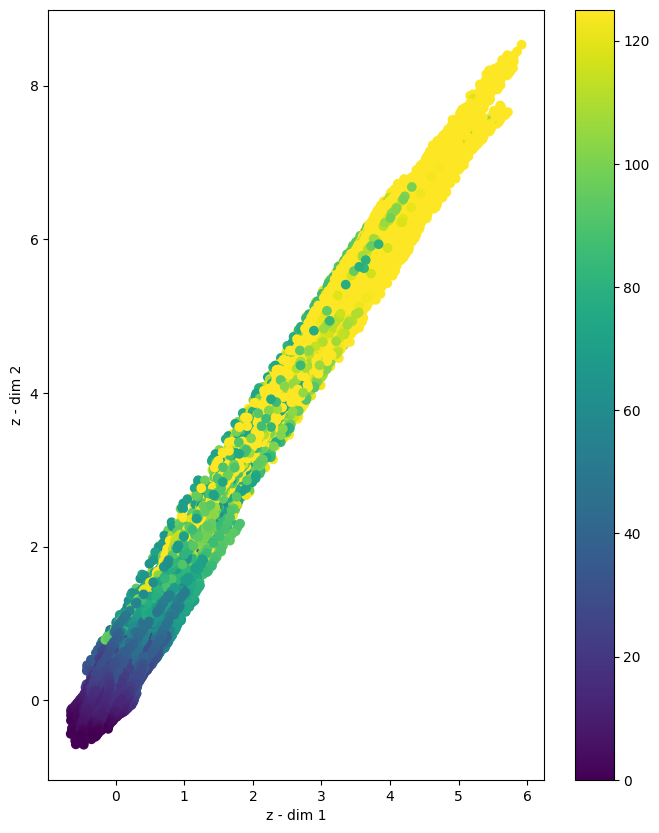

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


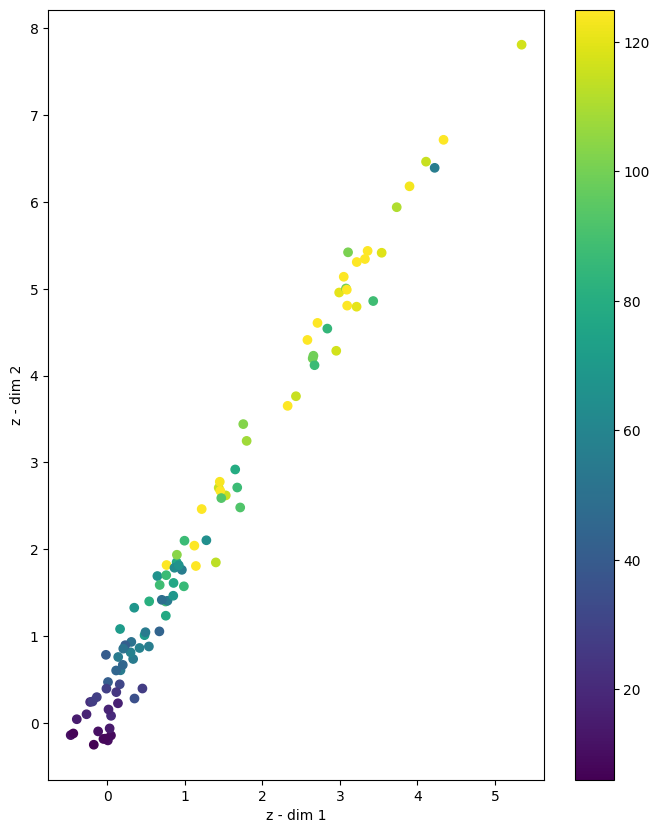

682/682 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
train set RMSE:13.387559929436648, R2:0.8956336975097656
test set RMSE:17.71202990676023, R2:0.8169255256652832


In [17]:
train_mu = utils.viz_latent_space(rve.encoder, np.concatenate((x_train, x_val)), np.concatenate((y_train, y_val)))
test_mu = utils.viz_latent_space(rve.encoder, x_test, y_test.clip(upper=threshold))
# Evaluate
y_hat_train = rve.regressor.predict(train_mu)
y_hat_test = rve.regressor.predict(test_mu)

utils.evaluate(np.concatenate((y_train, y_val)), y_hat_train, 'train')
utils.evaluate(y_test, y_hat_test, 'test')